# Build a TextCNN  model

In this notebook, we are going to build a Convolutional Neural Network model according to the following paper: https://arxiv.org/pdf/1408.5882.pdf. The model will be trained on the top of the pre-trained Glove embeddings.

#### Convolution

Convolutional neural networks  (CNN)  utilize layers with convolving features detectors, also referred to as kernels or filters that are applied to the input image or previous convolution layer output. The filter moves through the entire image with the stride of 1, at each step the element-wise multiplication and then the sum is calculated between all the values of the image that are encompassed by the current kernel position and the filters values. The map that results from that operation is called the feature map. By using different kernels we can obtain many feature maps that will build the convolutional layer.

By applying the feature detector, we:
- get rid of some unnecessary information,
- can reduce the size of the image,
- detect features,
- take into consideration that given features can appear in a different part of the image.
<br>
<br>
<div>
<img src="assets/An-example-of-convolution-operation-in-2D-2.png" width="450" />
<div/>
<p style='text-align: center;'>Convolution operation [by Ihab S. Mohamed, https://www.researchgate.net/figure/An-example-of-convolution-operation-in-2D-2_fig3_324165524]</p>

#### ReLU layer

On top of the convolutional layer, we have to apply the ReLU function to increase the non-linearity in our model. Feature detectors can contain negative values, so to get rid of them and at the same time prevent the model from interpreting changes from positive to negative values in our image as linear dependant we will apply the ReLU function.

#### Max Pooling layer

Spatial invariance is the feature of neural network thanks to which the model is capable of recognizing the same features even if they are a bit different, have different texture, shape or orientation. The max-pooling operation simply takes the maximum value from the max-pooling box that is applied to the feature map. High numbers on the feature map are representing the high similarity to given feature, so by taking the maximum values we will get rid of irrelevant features, and at the same time because we take the maximum from for example the 2x2 box we enable spatial invariance of the model because it doesn't matter if the feature is located on the top left corner or bottom right corner of the max-pooling box we still are able to extract that feature.
<br>
<br>
<div>
<img src="assets/MaxpoolSample2.png" width="400" />
<div/>
<p style='text-align: center;'>Max-pooling operation [https://computersciencewiki.org/index.php/Max-pooling_/_Pooling]</p>

<br>

#### Model's architecture

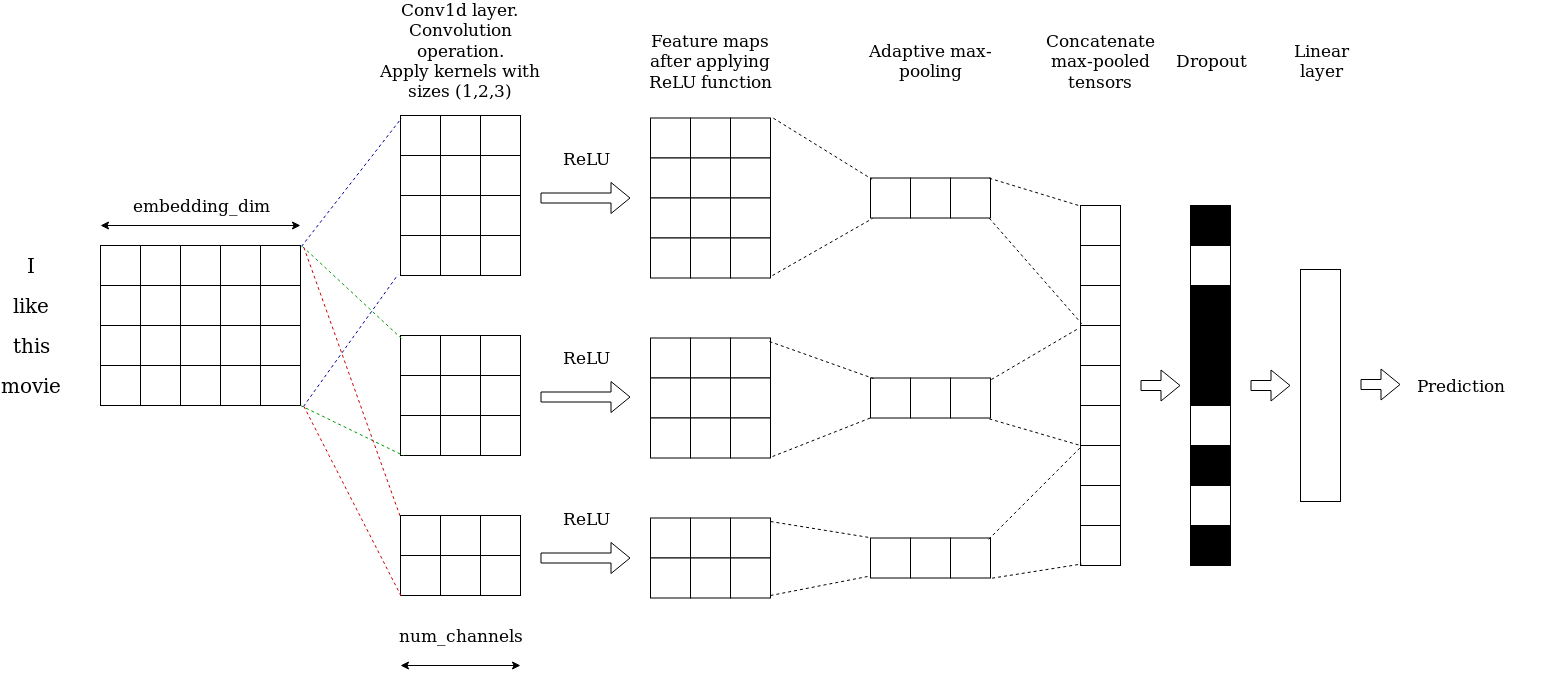

The convolution layer consists of feature maps that are created based on the input word embeddings by performing convolution operations using multiple filter sizes. Using different kernel sizes enable the model to find different features (n-grams). Next, the adaptive max-pooling is applied to the convolving output after going through the ReLU activation function. Max-pooled tensors are concatenated and pass on to the dropout layer, and then to the linear layer.

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Now, we are going to load the tarining and validation sets, but we will use only the clean_review column and label column.

In [2]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('dataset/datasets_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'label'])

# Change columns order
train_dataset = train_dataset[['clean_review', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset.head()

,clean_review,label
0,amaze good wonderful film early ninety franchi...,1
1,wrong end see tell chick go crazy eat old woma...,0
2,guess emperor clothe see list pbs night hopefu...,0
3,earth well movie funny sweet good plot unique ...,1
4,doe eye high school student kathleen beller fi...,1


In [4]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/datasets_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'label'])

# Change columns order
val_dataset = val_dataset[['clean_review', 'label']]

In [5]:
# Depict the first 5 rows of the validation set
val_dataset.head()

,clean_review,label
0,go movie twice week sum word normally use ligh...,1
1,year big fan park work old boy time favorite.w...,0
2,movie potential handle differently need differ...,0
3,movie difficult review give away plot suffice ...,1
4,plot worth discussion hint corruption murder p...,0


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

To create the weights matrix we have to set use_pretrained_vectors=True and supply the weight file path, Glove vectors file name and the directory and the name of the file to which we will export the prepared weights matrix. To use different word embeddings, simply pass on their file to the BatchIterator class.

In [6]:
train_iterator = BatchIterator(train_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.7,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights-cnn.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
35371/130416 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 108
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 30905/35375 of pre-trained word vectors.
4470 vectors initialized to random numbers
Weights vectors saved into glove/weights-cnn.npy
Batches created


In [7]:
val_iterator = BatchIterator(val_dataset, batch_size=128, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.7, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
19357/59089 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 105
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [8]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_seq', 'target', 'x_lengths'])


Notice that the output batch has the dimensions: (batch_size, seq_len)

In [9]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 84])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


In [10]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([128, 40])
target shape:  torch.Size([128])
x_lengths shape:  torch.Size([128])


Next step is to build the biGRU model.

In [11]:
class TextCNN(nn.Module):
    """Text Convolutional Neural Network.
        
    Parameters
    ----------
    conv_config: dict
        Dictionary of convolution layer settings (keys: 'num_channels', 'kernel_sizes')
        Number of channels corresponds to the number of filters.
    weight_matrix: numpy.ndarray
        Matrix of pre-trained word embeddings.
    output_size: int
        Number of classes.
    dropout: float, optional (default=0.5)
        Probability of an element of the tensor to be zeroed.

    """
    
    def __init__(self, conv_config, weights_matrix, output_size, dropout=0.5):
        
        # Inherit everything from the nn.Module
        super(TextCNN, self).__init__()
        
        # Initialize attributes
        self.conv_config = conv_config
        self.output_size = output_size
        self.weights_matrix = weights_matrix
        self.dropout_p = dropout
        self.vocab_size, self.embedding_dim = self.weights_matrix.shape
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # Load the weights to the embedding layer
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        self.embedding.weight.requires_grad = False          
            
        self.convolutions = nn.ModuleList([nn.Sequential(
            nn.Conv1d(self.embedding_dim, self.conv_config['num_channels'], kernel_size=kernel),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d((1,)))\
                         for kernel in self.conv_config['kernel_sizes']])    
            
        self.dropout = nn.Dropout(self.dropout_p)    
        self.linear = nn.Linear(self.conv_config['num_channels'] * len(self.conv_config['kernel_sizes']),\
                                                                       self.output_size)

        
    def forward(self, input_seq):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, embedding_dim, seq_length)
        emb_out = self.embedding(input_seq).permute(0,2,1)

        # Conv1d -> Relu -> AdaptiveMaxPool1d
        # Input: (batch_size, embedding_dim, seq_length)
        # Output: (batch_size, num_channels)
        conv_out = [conv(emb_out).squeeze(2) for conv in self.convolutions]       

        # Concatenate the list of convolving outputs from the previous step
        concat_out = torch.cat(conv_out, dim=1)

        concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [12]:
# Initialize parameters
conv_config = {'num_channels': 50, 'kernel_sizes': [1,2,3]}
output_size = 2
learning_rate = 0.001
epochs = 50
dropout = 0.8

# Load the weights matrix
weights = np.load('glove/weights-cnn.npy')

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = TextCNN(conv_config, weights, output_size, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/50]


Iteration: 100. Average training loss: 0.7059. Accuracy: 0.554
Iteration: 200. Average training loss: 0.6148. Accuracy: 0.607





Epoch [1/50]: Train accuracy: 0.632. Train loss: 0.6385. Evaluation accuracy: 0.786. Evaluation loss: 0.5063

Start epoch [2/50]


Iteration: 100. Average training loss: 0.5417. Accuracy: 0.731
Iteration: 200. Average training loss: 0.5249. Accuracy: 0.737





Epoch [2/50]: Train accuracy: 0.740. Train loss: 0.5299. Evaluation accuracy: 0.805. Evaluation loss: 0.4510

Start epoch [3/50]


Iteration: 100. Average training loss: 0.5009. Accuracy: 0.758
Iteration: 200. Average training loss: 0.4942. Accuracy: 0.761





Epoch [3/50]: Train accuracy: 0.762. Train loss: 0.4986. Evaluation accuracy: 0.812. Evaluation loss: 0.4358

Start epoch [4/50]


Iteration: 100. Average training loss: 0.4752. Accuracy: 0.778
Iteration: 200. Average training loss: 0.4814. Accuracy: 0.775





Epoch [4/50]: Train accuracy: 0.775. Train loss: 0.4799. Evaluation accuracy: 0.817. Evaluation loss: 0.4209

Start epoch [5/50]


Iteration: 100. Average training loss: 0.4638. Accuracy: 0.785
Iteration: 200. Average training loss: 0.4645. Accuracy: 0.784





Epoch [5/50]: Train accuracy: 0.783. Train loss: 0.4672. Evaluation accuracy: 0.818. Evaluation loss: 0.4172

Start epoch [6/50]


Iteration: 100. Average training loss: 0.4574. Accuracy: 0.787
Iteration: 200. Average training loss: 0.4570. Accuracy: 0.788





Epoch [6/50]: Train accuracy: 0.787. Train loss: 0.4589. Evaluation accuracy: 0.822. Evaluation loss: 0.4083

Start epoch [7/50]


Iteration: 100. Average training loss: 0.4410. Accuracy: 0.799
Iteration: 200. Average training loss: 0.4521. Accuracy: 0.793





Epoch [7/50]: Train accuracy: 0.792. Train loss: 0.4511. Evaluation accuracy: 0.821. Evaluation loss: 0.4055

Start epoch [8/50]


Iteration: 100. Average training loss: 0.4408. Accuracy: 0.798
Iteration: 200. Average training loss: 0.4429. Accuracy: 0.797





Epoch [8/50]: Train accuracy: 0.796. Train loss: 0.4441. Evaluation accuracy: 0.825. Evaluation loss: 0.4006

Start epoch [9/50]


Iteration: 100. Average training loss: 0.4354. Accuracy: 0.802
Iteration: 200. Average training loss: 0.4390. Accuracy: 0.801





Epoch [9/50]: Train accuracy: 0.800. Train loss: 0.4388. Evaluation accuracy: 0.827. Evaluation loss: 0.3957

Start epoch [10/50]


Iteration: 100. Average training loss: 0.4291. Accuracy: 0.807
Iteration: 200. Average training loss: 0.4367. Accuracy: 0.806





Epoch [10/50]: Train accuracy: 0.804. Train loss: 0.4362. Evaluation accuracy: 0.829. Evaluation loss: 0.3970

Start epoch [11/50]


Iteration: 100. Average training loss: 0.4287. Accuracy: 0.806
Iteration: 200. Average training loss: 0.4288. Accuracy: 0.806





Epoch [11/50]: Train accuracy: 0.804. Train loss: 0.4321. Evaluation accuracy: 0.831. Evaluation loss: 0.3889

Start epoch [12/50]


Iteration: 100. Average training loss: 0.4207. Accuracy: 0.809
Iteration: 200. Average training loss: 0.4270. Accuracy: 0.809





Epoch [12/50]: Train accuracy: 0.807. Train loss: 0.4273. Evaluation accuracy: 0.832. Evaluation loss: 0.3867

Start epoch [13/50]


Iteration: 100. Average training loss: 0.4169. Accuracy: 0.813
Iteration: 200. Average training loss: 0.4188. Accuracy: 0.812





Epoch [13/50]: Train accuracy: 0.811. Train loss: 0.4204. Evaluation accuracy: 0.832. Evaluation loss: 0.3850

Start epoch [14/50]


Iteration: 100. Average training loss: 0.4164. Accuracy: 0.812
Iteration: 200. Average training loss: 0.4208. Accuracy: 0.812





Epoch [14/50]: Train accuracy: 0.809. Train loss: 0.4221. Evaluation accuracy: 0.831. Evaluation loss: 0.3820

Start epoch [15/50]


Iteration: 100. Average training loss: 0.4080. Accuracy: 0.818
Iteration: 200. Average training loss: 0.4142. Accuracy: 0.816





Epoch [15/50]: Train accuracy: 0.814. Train loss: 0.4157. Evaluation accuracy: 0.834. Evaluation loss: 0.3816

Start epoch [16/50]


Iteration: 100. Average training loss: 0.4102. Accuracy: 0.814
Iteration: 200. Average training loss: 0.4197. Accuracy: 0.812





Epoch [16/50]: Train accuracy: 0.811. Train loss: 0.4188. Evaluation accuracy: 0.834. Evaluation loss: 0.3834

Start epoch [17/50]


Iteration: 100. Average training loss: 0.4080. Accuracy: 0.817
Iteration: 200. Average training loss: 0.4126. Accuracy: 0.816





Epoch [17/50]: Train accuracy: 0.813. Train loss: 0.4134. Evaluation accuracy: 0.834. Evaluation loss: 0.3816

Start epoch [18/50]


Iteration: 100. Average training loss: 0.3976. Accuracy: 0.825
Iteration: 200. Average training loss: 0.4110. Accuracy: 0.820





Epoch [18/50]: Train accuracy: 0.818. Train loss: 0.4090. Evaluation accuracy: 0.837. Evaluation loss: 0.3794

Start epoch [19/50]


Iteration: 100. Average training loss: 0.3961. Accuracy: 0.822
Iteration: 200. Average training loss: 0.4182. Accuracy: 0.817





Epoch [19/50]: Train accuracy: 0.815. Train loss: 0.4106. Evaluation accuracy: 0.835. Evaluation loss: 0.3775

Start epoch [20/50]


Iteration: 100. Average training loss: 0.3969. Accuracy: 0.826
Iteration: 200. Average training loss: 0.4038. Accuracy: 0.824





Epoch [20/50]: Train accuracy: 0.821. Train loss: 0.4051. Evaluation accuracy: 0.838. Evaluation loss: 0.3727

Start epoch [21/50]


Iteration: 100. Average training loss: 0.3947. Accuracy: 0.822
Iteration: 200. Average training loss: 0.4038. Accuracy: 0.818





Epoch [21/50]: Train accuracy: 0.818. Train loss: 0.4040. Evaluation accuracy: 0.839. Evaluation loss: 0.3737

Start epoch [22/50]


Iteration: 100. Average training loss: 0.3964. Accuracy: 0.822
Iteration: 200. Average training loss: 0.4023. Accuracy: 0.821





Epoch [22/50]: Train accuracy: 0.819. Train loss: 0.4032. Evaluation accuracy: 0.838. Evaluation loss: 0.3731

Start epoch [23/50]


Iteration: 100. Average training loss: 0.3927. Accuracy: 0.827
Iteration: 200. Average training loss: 0.4021. Accuracy: 0.826





Epoch [23/50]: Train accuracy: 0.824. Train loss: 0.4014. Evaluation accuracy: 0.838. Evaluation loss: 0.3699

Start epoch [24/50]


Iteration: 100. Average training loss: 0.3863. Accuracy: 0.829
Iteration: 200. Average training loss: 0.3961. Accuracy: 0.827





Epoch [24/50]: Train accuracy: 0.824. Train loss: 0.3952. Evaluation accuracy: 0.839. Evaluation loss: 0.3712

Start epoch [25/50]


Iteration: 100. Average training loss: 0.3893. Accuracy: 0.829
Iteration: 200. Average training loss: 0.3957. Accuracy: 0.827





Epoch [25/50]: Train accuracy: 0.824. Train loss: 0.3988. Evaluation accuracy: 0.840. Evaluation loss: 0.3666

Start epoch [26/50]


Iteration: 100. Average training loss: 0.3822. Accuracy: 0.833
Iteration: 200. Average training loss: 0.3993. Accuracy: 0.829





Epoch [26/50]: Train accuracy: 0.825. Train loss: 0.3960. Evaluation accuracy: 0.839. Evaluation loss: 0.3667

Start epoch [27/50]


Iteration: 100. Average training loss: 0.3824. Accuracy: 0.828
Iteration: 200. Average training loss: 0.3955. Accuracy: 0.826





Epoch [27/50]: Train accuracy: 0.824. Train loss: 0.3940. Evaluation accuracy: 0.841. Evaluation loss: 0.3665

Start epoch [28/50]


Iteration: 100. Average training loss: 0.3801. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3929. Accuracy: 0.830





Epoch [28/50]: Train accuracy: 0.827. Train loss: 0.3924. Evaluation accuracy: 0.839. Evaluation loss: 0.3688

Start epoch [29/50]


Iteration: 100. Average training loss: 0.3873. Accuracy: 0.826
Iteration: 200. Average training loss: 0.3907. Accuracy: 0.828





Epoch [29/50]: Train accuracy: 0.826. Train loss: 0.3918. Evaluation accuracy: 0.840. Evaluation loss: 0.3636

Start epoch [30/50]


Iteration: 100. Average training loss: 0.3792. Accuracy: 0.831
Iteration: 200. Average training loss: 0.3901. Accuracy: 0.831





Epoch [30/50]: Train accuracy: 0.829. Train loss: 0.3882. Evaluation accuracy: 0.841. Evaluation loss: 0.3642

Start epoch [31/50]


Iteration: 100. Average training loss: 0.3770. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3908. Accuracy: 0.831





Epoch [31/50]: Train accuracy: 0.828. Train loss: 0.3898. Evaluation accuracy: 0.840. Evaluation loss: 0.3647

Start epoch [32/50]


Iteration: 100. Average training loss: 0.3788. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3896. Accuracy: 0.831





Epoch [32/50]: Train accuracy: 0.828. Train loss: 0.3875. Evaluation accuracy: 0.843. Evaluation loss: 0.3632

Start epoch [33/50]


Iteration: 100. Average training loss: 0.3820. Accuracy: 0.831
Iteration: 200. Average training loss: 0.3897. Accuracy: 0.829





Epoch [33/50]: Train accuracy: 0.827. Train loss: 0.3904. Evaluation accuracy: 0.841. Evaluation loss: 0.3622

Start epoch [34/50]


Iteration: 100. Average training loss: 0.3699. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3843. Accuracy: 0.834





Epoch [34/50]: Train accuracy: 0.831. Train loss: 0.3830. Evaluation accuracy: 0.840. Evaluation loss: 0.3634

Start epoch [35/50]


Iteration: 100. Average training loss: 0.3765. Accuracy: 0.833
Iteration: 200. Average training loss: 0.3839. Accuracy: 0.833





Epoch [35/50]: Train accuracy: 0.831. Train loss: 0.3850. Evaluation accuracy: 0.842. Evaluation loss: 0.3628

Start epoch [36/50]


Iteration: 100. Average training loss: 0.3768. Accuracy: 0.835
Iteration: 200. Average training loss: 0.3876. Accuracy: 0.833





Epoch [36/50]: Train accuracy: 0.831. Train loss: 0.3862. Evaluation accuracy: 0.842. Evaluation loss: 0.3626

Start epoch [37/50]


Iteration: 100. Average training loss: 0.3675. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3845. Accuracy: 0.834





Epoch [37/50]: Train accuracy: 0.831. Train loss: 0.3822. Evaluation accuracy: 0.843. Evaluation loss: 0.3611

Start epoch [38/50]


Iteration: 100. Average training loss: 0.3722. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3795. Accuracy: 0.834





Epoch [38/50]: Train accuracy: 0.832. Train loss: 0.3816. Evaluation accuracy: 0.845. Evaluation loss: 0.3610

Start epoch [39/50]


Iteration: 100. Average training loss: 0.3754. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3782. Accuracy: 0.834





Epoch [39/50]: Train accuracy: 0.832. Train loss: 0.3811. Evaluation accuracy: 0.844. Evaluation loss: 0.3605

Start epoch [40/50]


Iteration: 100. Average training loss: 0.3780. Accuracy: 0.835
Iteration: 200. Average training loss: 0.3792. Accuracy: 0.834





Epoch [40/50]: Train accuracy: 0.832. Train loss: 0.3806. Evaluation accuracy: 0.843. Evaluation loss: 0.3605

Start epoch [41/50]


Iteration: 100. Average training loss: 0.3733. Accuracy: 0.835
Iteration: 200. Average training loss: 0.3759. Accuracy: 0.835





Epoch [41/50]: Train accuracy: 0.833. Train loss: 0.3808. Evaluation accuracy: 0.843. Evaluation loss: 0.3612

Start epoch [42/50]


Iteration: 100. Average training loss: 0.3659. Accuracy: 0.841
Iteration: 200. Average training loss: 0.3735. Accuracy: 0.838





Epoch [42/50]: Train accuracy: 0.835. Train loss: 0.3750. Evaluation accuracy: 0.844. Evaluation loss: 0.3586

Start epoch [43/50]


Iteration: 100. Average training loss: 0.3698. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3807. Accuracy: 0.837





Epoch [43/50]: Train accuracy: 0.835. Train loss: 0.3791. Evaluation accuracy: 0.845. Evaluation loss: 0.3615

Start epoch [44/50]


Iteration: 100. Average training loss: 0.3714. Accuracy: 0.837
Iteration: 200. Average training loss: 0.3689. Accuracy: 0.838





Epoch [44/50]: Train accuracy: 0.835. Train loss: 0.3759. Evaluation accuracy: 0.845. Evaluation loss: 0.3614

Start epoch [45/50]


Iteration: 100. Average training loss: 0.3708. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3733. Accuracy: 0.836





Epoch [45/50]: Train accuracy: 0.833. Train loss: 0.3789. Evaluation accuracy: 0.847. Evaluation loss: 0.3544

Start epoch [46/50]


Iteration: 100. Average training loss: 0.3640. Accuracy: 0.841
Iteration: 200. Average training loss: 0.3738. Accuracy: 0.840





Epoch [46/50]: Train accuracy: 0.836. Train loss: 0.3770. Evaluation accuracy: 0.846. Evaluation loss: 0.3567

Start epoch [47/50]


Iteration: 100. Average training loss: 0.3609. Accuracy: 0.839
Iteration: 200. Average training loss: 0.3753. Accuracy: 0.838





Epoch [47/50]: Train accuracy: 0.834. Train loss: 0.3740. Evaluation accuracy: 0.845. Evaluation loss: 0.3580

Start epoch [48/50]


Iteration: 100. Average training loss: 0.3591. Accuracy: 0.846
Iteration: 200. Average training loss: 0.3718. Accuracy: 0.841





Epoch [48/50]: Train accuracy: 0.838. Train loss: 0.3718. Evaluation accuracy: 0.842. Evaluation loss: 0.3602

Training stoped by EarlyStopping


In [13]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

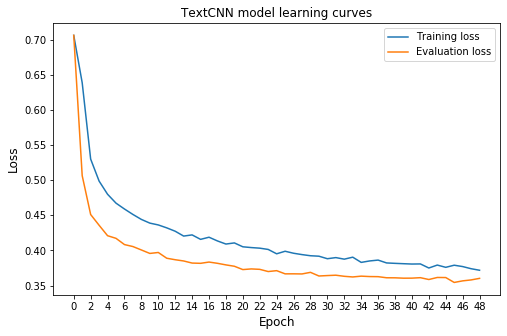

In [14]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('TextCNN model learning curves')
plt.xticks(ticks=range(0,49,2))
plt.legend()
plt.show()

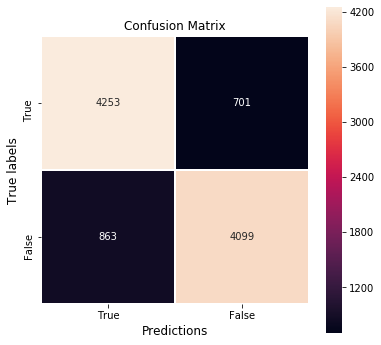

In [15]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The model achieved the validation accuracy of 0.847, while the training accuracy was 0.833. The model's best state was saved to the *checkpoint.pt* file in the current directory.

### The generalization error

In [16]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/datasets_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'label'])

# Change columns order
test_dataset = test_dataset[['clean_review', 'label']]

In [17]:
test_dataset.head()

,clean_review,label
0,hear film till pop cable tv understand geena o...,1
1,know film show local tv kid remember watch see...,0
2,admire kiss mouth frankness  pubic hair cut m...,0
3,see cure kid love year late get hold copy acci...,1
4,movie true fact see documentary day early movi...,0


In [18]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
13480/39104 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 187
Mapped words to indices
Batches created


In [19]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

In [20]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.859. Test error: 0.340


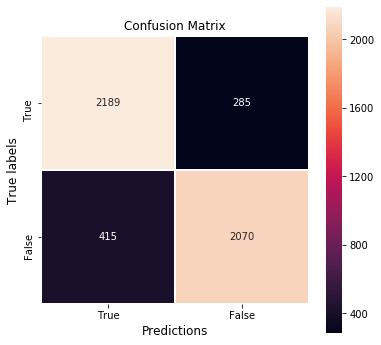

In [21]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The generalization accuracy of the TextCNN model is 0.859. As we can see in the above plot of the confusion matrix the number of False negative predictions (285) is less than the amount of False positive predictions (415) which indicates that our model didn't learn both classes in the same detail.